In [1]:
%config IPCompleter.greedy=True

In [2]:
from dask.distributed import Client
#client = Client('dcache-dot1.desy.de:8001')
client = Client()
client

<Client: 'tcp://127.0.0.1:42298' processes=6 threads=24, memory=67.33 GB>

In [3]:
import numpy as np
import dask.array as da
X_train = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_train.npy")
Y_train = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_train.npy")

Convert the numpy arrays to dask arrays

In [4]:
X_train = da.from_array(X_train, chunks=50000)
Y_train = da.from_array(Y_train, chunks=50000)

In [5]:
import xgboost as xgb

In [6]:
import dask
X_train.persist()
Y_train.persist()

dask.array<array, shape=(4254508,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

In [7]:
split_fraction = 0.8
lam = 0
alpha = 0
max_depth = 4
gamma = 0
eta = 0.99
min_child_weight = 0.0
subsample = 0.9
colsample_bytree = 0.8
xgb_early_stopping = 5
n_threads = -1
positive_scale = 1
num_class = 5
n_rounds = 200

In [8]:
param = {
    "lambda": lam,
    "alpha": alpha,
    "max_depth": max_depth,
    "gamma": gamma,
    "eta": eta,
    "objective": "multi:softprob",
    "nthread": n_threads,
    "tree_method": "hist",
    "eval_metric": ["merror", "mlogloss"],
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "seed": 123,
    "random_state": 123,
    "num_class":num_class
}

In [9]:
Y_train

dask.array<array, shape=(4254508,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

In [10]:
X_train

dask.array<array, shape=(4254508, 35), dtype=float64, chunksize=(50000, 35), chunktype=numpy.ndarray>

In [11]:
import dask_xgboost
bst_xgboost = dask_xgboost.train(client, param, X_train, Y_train, num_boost_round=10)# XGBoost's API

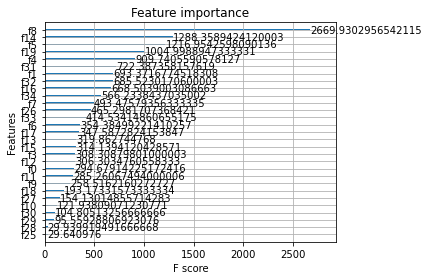

In [12]:
%matplotlib inline
import xgboost
import matplotlib.pyplot as plt
by_gain = xgboost.plot_importance(bst_xgboost, importance_type="gain")
plt.tight_layout()

In [13]:
X_test = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/X_test.npy")
Y_test = np.load("/nfs/dust/atlas/user/hteagle/PyAnalysisUtils/ML/NN/data/processed/xgboost-Wh_nominal_reco/Y_test.npy")
X_test = da.from_array(X_test, chunks=50000)
Y_test = da.from_array(Y_test, chunks=50000)

In [14]:
X_test.persist()
Y_test.persist()

dask.array<array, shape=(1063628,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

In [15]:
from dask_ml.xgboost import XGBClassifier
from xgboost import Booster


In [16]:
clf = XGBClassifier()
clf._Booster = bst_xgboost
clf.predict(X_test)

dask.array<arg_agg-aggregate, shape=(1063628,), dtype=int64, chunksize=(50000,), chunktype=numpy.ndarray>

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [18]:
Y_hat = dask_xgboost.predict(client, bst_xgboost, X_test).persist()

In [19]:
classes = ["Signal", "ttbar", "st", "W", "other"]
Y_test, Y_hat = dask.compute(Y_test, Y_hat)
Y_test_binarised = label_binarize(Y_test, classes=[0,1,2,3,4])

In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(param['num_class']):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarised[:, i], Y_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

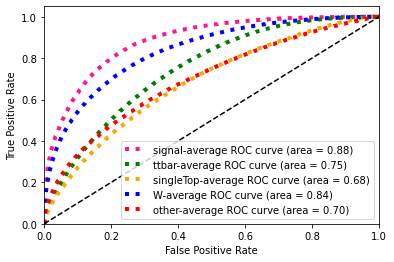

In [21]:

plt.figure()
plt.plot(fpr[0], tpr[0],
         label='signal-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[0]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr[1], tpr[1],
         label='ttbar-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[1]),
         color='green', linestyle=':', linewidth=4)
plt.plot(fpr[2], tpr[2],
         label='singleTop-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[2]),
         color='orange', linestyle=':', linewidth=4)
plt.plot(fpr[3], tpr[3],
         label='W-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[3]),
         color='blue', linestyle=':', linewidth=4)
plt.plot(fpr[4], tpr[4],
         label='other-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[4]),
         color='red', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Let's try some analysis with yellowbrick?

/afs/desy.de/user/h/hteagle/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/afs/desy.de/user/h/hteagle/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


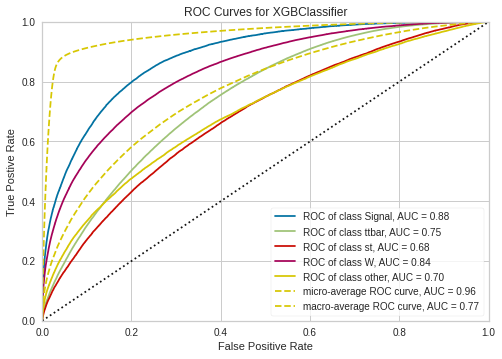

/afs/desy.de/user/h/hteagle/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7ff931178a58>,
       classes=['Signal', 'ttbar', 'st', 'W', 'other'], is_fitted=True,
       model=None)

In [22]:
from yellowbrick.classifier.rocauc import roc_auc
roc_auc(clf, X_train, Y_train, X_test=X_test, y_test=Y_test, classes=classes, is_fitted=True)

Let's try some hyperparameter optimisation

In [23]:
from dask_ml.model_selection import GridSearchCV
opt_clf = XGBClassifier()
hyparams={}
for par, val in param.items():
    hyparams[par]=[val]
param["eta"] = [0.2,0.5,0.9]
search = GridSearchCV(opt_clf,hyparams, scoring='roc_auc')

In [24]:
search.fit(X_train, Y_train)
client.gather()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [ ]:
client.close